# cat_dog_classifier

In [1]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [2]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
import pathlib
dataset_url = "https://datasets-349058029.s3.us-west-2.amazonaws.com/cat_dog_classifier/cat_dog.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir.replace('.zip', ''))
print(f"{len(list(data_dir.glob('*/*.jpg')))} images in dataset")

25000 images in dataset


In [4]:
batch_size = 64
img_size = 200

ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

data_augmentation_fn = lambda x, y: (data_augmentation(x, training=True), y)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_size = int(train_split * len(ds))
val_size = int(val_split * len(ds))

train_ds = ds.take(train_size).map(data_augmentation_fn, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE) 
val_ds = ds.skip(train_size).take(val_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = ds.skip(train_size).skip(val_size).prefetch(buffer_size=AUTOTUNE) 

In [7]:
model_name = '00'

model = tf.keras.Sequential([
  layers.InputLayer(input_shape=(img_size, img_size, 3)),
  # layers.Resizing(img_size, img_size),
  layers.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{model_name}',
    histogram_freq=1)

In [9]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'models/{model_name}.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [10]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[tensorboard_callback, model_checkpoint_callback]
  callbacks=[model_checkpoint_callback]
)

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


312/312 [==============================] - 36s 106ms/step - loss: 0.6479 - accuracy: 0.6256 - val_loss: 0.5671 - val_accuracy: 0.7047
Epoch 2/15
312/312 [==============================] - 34s 108ms/step - loss: 0.5772 - accuracy: 0.6927 - val_loss: 0.5403 - val_accuracy: 0.7248
Epoch 3/15
312/312 [==============================] - 35s 111ms/step - loss: 0.5463 - accuracy: 0.7249 - val_loss: 0.5009 - val_accuracy: 0.7548
Epoch 4/15
312/312 [==============================] - 35s 110ms/step - loss: 0.5262 - accuracy: 0.7364 - val_loss: 0.4784 - val_accuracy: 0.7728
Epoch 5/15
312/312 [==============================] - 34s 107ms/step - loss: 0.5074 - accuracy: 0.7485 - val_loss: 0.4692 - val_accuracy: 0.7760
Epoch 6/15
312/312 [==============================] - 34s 108ms/step - loss: 0.4932 - accuracy: 0.7618 - val_loss: 0.4719 - val_accuracy: 0.7776
Epoch 7/15
312/312 [==============================] - 35s 109ms/step - loss: 0.4819 - accuracy: 0.7665 - val_loss: 0.4563 - val_accuracy: 0.7

In [11]:
model = tf.keras.models.load_model(f'models/{model_name}.h5')
model.evaluate(test_ds)

40/40 [==============================] - 6s 29ms/step - loss: 0.4068 - accuracy: 0.8190


[0.40680378675460815, 0.8190063238143921]

[[0.94813573 0.05186424]]
['Cat', 'Dog']
Cat 0.94813573


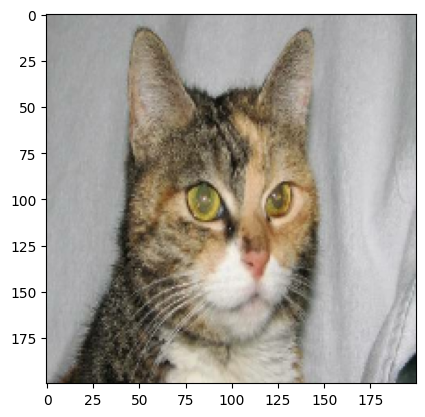

In [21]:
tensor = list(ds.take(1))[0][0][0]
pred = model.predict(tf.expand_dims(tensor, 0))
print(pred)
print(ds.class_names)
print(ds.class_names[pred.argmax()], pred.max())
im = tf.keras.utils.img_to_array(tensor, dtype=int)
plt.imshow(im)
plt.show()


In [13]:
# tfjs.converters.save_keras_model(model, './test_tfjs_model')

In [1]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model ./models/00.h5 ./test_tfjs_model

2022-03-23 10:25:48.553126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:25:48.557971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:25:48.558289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 10:25:48.558641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags